In [1]:
# Load a few packages first 

In [2]:
import argparse
import logging
import os
import random
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from pathlib import Path
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

import wandb
from evaluate_2 import evaluate_2
from unet_2 import UNet_2
from utils.data_loading_2 import BasicDataset_2, CarvanaDataset_2
from utils.loss_calculator import calculate_loss


In [7]:
model = UNet_2(n_channels=1, n_classes=1, bilinear=False)

In [3]:
for tag, value in model.named_parameters():
    histograms = {}
    tag = tag.replace('/', '.')
    print(tag)
    if not (torch.isinf(value) | torch.isnan(value)).any():
        histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
    if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
        histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

inc.double_conv.0.weight


TypeError: isinf(): argument 'input' (position 1) must be Tensor, not NoneType

In [4]:
for tag, value in model.named_parameters():
    histograms = {}
    tag = tag.replace('/', '.')
    print(tag)
    if not (torch.isinf(value) | torch.isnan(value)).any():
        histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
    if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
        histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

inc.double_conv.0.weight


TypeError: isinf(): argument 'input' (position 1) must be Tensor, not NoneType

In [5]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

inc.double_conv.0.weight
inc.double_conv.1.weight
inc.double_conv.1.bias
inc.double_conv.3.weight
inc.double_conv.4.weight
inc.double_conv.4.bias
down1.maxpool_conv.1.double_conv.0.weight
down1.maxpool_conv.1.double_conv.1.weight
down1.maxpool_conv.1.double_conv.1.bias
down1.maxpool_conv.1.double_conv.3.weight
down1.maxpool_conv.1.double_conv.4.weight
down1.maxpool_conv.1.double_conv.4.bias
down2.maxpool_conv.1.double_conv.0.weight
down2.maxpool_conv.1.double_conv.1.weight
down2.maxpool_conv.1.double_conv.1.bias
down2.maxpool_conv.1.double_conv.3.weight
down2.maxpool_conv.1.double_conv.4.weight
down2.maxpool_conv.1.double_conv.4.bias
down3.maxpool_conv.1.double_conv.0.weight
down3.maxpool_conv.1.double_conv.1.weight
down3.maxpool_conv.1.double_conv.1.bias
down3.maxpool_conv.1.double_conv.3.weight
down3.maxpool_conv.1.double_conv.4.weight
down3.maxpool_conv.1.double_conv.4.bias
down4.maxpool_conv.1.double_conv.0.weight
down4.maxpool_conv.1.double_conv.1.weight
down4.maxpool_conv.1.doubl

In [1]:
#dir_img = Path('./data/imgs/')
#dir_mask = Path('./data/masks/')
#dir_checkpoint = Path('./checkpoints/')


dir_img = 'Z:/Dongyu Fan/2. Data/ImageProcessing/Simulation/2024-10-02/test/img/'
dir_mask = 'Z:/Dongyu Fan/2. Data/ImageProcessing/Simulation/2024-10-02/test/mask/'
dir_D = 'Z:/Dongyu Fan/2. Data/ImageProcessing/Simulation/2024-10-02/test/Diffusion/'


In [34]:
dataset = CarvanaDataset_2(dir_img, dir_mask, dir_D, scale = 1)

INFO: Creating dataset with 100 examples
INFO: Scanning mask files to determine unique values
100%|██████████| 100/100 [00:11<00:00,  8.35it/s]
INFO: Unique mask values: [0, 1]


In [23]:
loader_args = dict(batch_size=1, num_workers=os.cpu_count(), pin_memory=True)
train_loader = DataLoader(dataset, shuffle=True, **loader_args)
for batch in train_loader:
    images, true_masks, true_D = batch['image'], batch['mask'], batch['D']

In [13]:
images.size()


torch.Size([1, 1, 32, 32])

In [3]:
from datetime import datetime
 # Define the base path
base_path = 'Z:/Dongyu Fan/2. Data/ImageProcessing/training'
# Get current date and time
now = datetime.now()
date_str = now.strftime('%Y-%m-%d')  # Format for date (e.g., '2024-08-26')
time_str = now.strftime('%m-%d_%H-%M')  # Format for time (e.g., '08-26_15-30')

# Create directory paths
date_folder = os.path.join(base_path, date_str)
time_folder = os.path.join(date_folder, time_str)

# Create directories
os.makedirs(time_folder, exist_ok=True)  # exist_ok=True to avoid error if the directory already exists

dir_checkpoint = time_folder
wandb_dir = time_folder

In [9]:
def train_model(
        model,
        device,
        epochs: int = 5,
        batch_size: int = 1,
        learning_rate: float = 1e-5,
        val_percent: float = 0.1,
        save_checkpoint: bool = True,
        img_scale: float = 0.5,
        amp: bool = False,
        weight_decay: float = 1e-8,
        momentum: float = 0.999,
        gradient_clipping: float = 1.0,
):
    
    # 1. Create dataset
    try:
        dataset = CarvanaDataset(dir_img, dir_mask, img_scale)
    except (AssertionError, RuntimeError, IndexError):
        dataset = BasicDataset(dir_img, dir_mask, img_scale)

    # 2. Split into train / validation partitions
    n_val = int(len(dataset) * val_percent)
    n_train = len(dataset) - n_val
    train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

    # 3. Create data loaders
    loader_args = dict(batch_size=batch_size, num_workers=os.cpu_count(), pin_memory=True)
    train_loader = DataLoader(train_set, shuffle=True, **loader_args)
    val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

    # (Initialize logging)
    experiment = wandb.init(project='U-Net', resume='allow', anonymous='must', dir = wandb_dir)
    experiment.config.update(
        dict(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
             val_percent=val_percent, save_checkpoint=save_checkpoint, img_scale=img_scale, amp=amp)
    )

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Checkpoints:     {save_checkpoint}
        Device:          {device.type}
        Images scaling:  {img_scale}
        Mixed Precision: {amp}
    ''')

    # 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
    optimizer = optim.RMSprop(model.parameters(),
                              lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)  # goal: maximize Dice score
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    #criterion = nn.CrossEntropyLoss() if model.n_classes > 1 else nn.BCEWithLogitsLoss()
    criterion =  nn.MSELoss()
    global_step = 0

    # 5. Begin training
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                images, true_masks = batch['image'], batch['mask']

                assert images.shape[1] == model.n_channels, \
                    f'Network has been defined with {model.n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    masks_pred = model(images)
                    if model.n_classes == 1:
                        loss = criterion(masks_pred.squeeze(1), true_masks.float())
                        loss += dice_loss(F.sigmoid(masks_pred.squeeze(1)), true_masks.float(), multiclass=False)
                    else:
                        loss = criterion(masks_pred, true_masks)
                        loss += dice_loss(
                            F.softmax(masks_pred, dim=1).float(),
                            F.one_hot(true_masks, model.n_classes).permute(0, 3, 1, 2).float(),
                            multiclass=True
                        )

                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                grad_scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                experiment.log({
                    'train loss': loss.item(),
                    'step': global_step,
                    'epoch': epoch
                })
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train // (5 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        histograms = {}
                        for tag, value in model.named_parameters():
                            tag = tag.replace('/', '.')
                            if not (torch.isinf(value) | torch.isnan(value)).any():
                                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                            if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                                histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

                        val_score = evaluate(model, val_loader, device, amp)
                        scheduler.step(val_score)

                        logging.info('Validation Dice score: {}'.format(val_score))
                        try:
                            experiment.log({
                                'learning rate': optimizer.param_groups[0]['lr'],
                                'validation Dice': val_score,
                                'images': wandb.Image(images[0].cpu()),
                                'masks': {
                                    'true': wandb.Image(true_masks[0].float().cpu()),
                                    'pred': wandb.Image(masks_pred.argmax(dim=1)[0].float().cpu()),
                                },
                                'step': global_step,
                                'epoch': epoch,
                                **histograms
                            })
                        except:
                            pass

        if save_checkpoint:
            Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
            state_dict = model.state_dict()
            state_dict['mask_values'] = dataset.mask_values
            torch.save(state_dict, str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch)))
            logging.info(f'Checkpoint {epoch} saved!')


In [10]:
#args = get_args()

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device {device}')

# Change here to adapt to your data
# n_channels=3 for RGB images
# n_classes is the number of probabilities you want to get per pixel
model = UNet(n_channels=1, n_classes=1, bilinear=False)
model = model.to(memory_format=torch.channels_last)

logging.info(f'Network:\n'
                 f'\t{model.n_channels} input channels\n'
                 f'\t{model.n_classes} output channels (classes)\n'
                 f'\t{"Bilinear" if model.bilinear else "Transposed conv"} upscaling')

model.to(device=device)
try:
    train_model(
        model=model,
        epochs=5,
        batch_size=16,
        learning_rate=1e-5,
        device=device,
        img_scale=1.,
        val_percent=0.5 / 100,
        amp=False
    )
except torch.cuda.OutOfMemoryError:
    logging.error('Detected OutOfMemoryError! '
                    'Enabling checkpointing to reduce memory usage, but this slows down training. '
                    'Consider enabling AMP (--amp) for fast and memory efficient training')
    torch.cuda.empty_cache()
    model.use_checkpointing()
    train_model(
        model=model,
        epochs=5,
        batch_size=1,
        learning_rate=1e-5,
        device=device,
        img_scale=1,
        val_percent=0.5 / 100,
        amp=False
    )


INFO: Using device cpu


NameError: name 'UNet' is not defined

In [5]:
def test_train(
        model,
        device,
        epochs: int = 5,
        batch_size: int = 1,
        learning_rate: float = 1e-4,
        val_percent: float = 10,
        save_checkpoint: bool = True,
        img_scale: float = 0.5,
        amp: bool = False,
        weight_decay: float = 1e-8,
        momentum: float = 0.999,
        gradient_clipping: float = 1.0,
        wandb_log = False
):
    
    # 1. Create dataset
    try:
        dataset = CarvanaDataset_2(dir_img, dir_mask, dir_D, img_scale)
    except (AssertionError, RuntimeError, IndexError):
        dataset = BasicDataset_2(dir_img, dir_mask, dir_D, img_scale)

    # 2. Split into train / validation partitions
    n_val = int(len(dataset) * val_percent)
    n_train = len(dataset) - n_val
    train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

    # 3. Create data loaders
    loader_args = dict(batch_size=batch_size, num_workers=os.cpu_count(), pin_memory=True)
    train_loader = DataLoader(train_set, shuffle=True, **loader_args)
    val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)
    # (Initialize logging)
    if wandb_log:
        experiment = wandb.init(project='U-Net-D', resume='allow', anonymous='must', dir = wandb_dir)
        experiment.config.update(
            dict(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
                 val_percent=val_percent, save_checkpoint=save_checkpoint, img_scale=img_scale, amp=amp)
        )


    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Checkpoints:     {save_checkpoint}
        Device:          {device.type}
        Images scaling:  {img_scale}
        Mixed Precision: {amp}
    ''')

    # 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
    optimizer = optim.RMSprop(model.parameters(),
                              lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)  # goal: maximize Dice score
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    #criterion = nn.CrossEntropyLoss() if model.n_classes > 1 else nn.BCEWithLogitsLoss()

    global_step = 0

    # 5. Begin training
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                images, true_masks, true_D = batch['image'], batch['mask'], batch['D']

                assert images.shape[1] == model.n_channels, \
                    f'Network has been defined with {model.n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                
                true_masks = true_masks.to(device=device, dtype=torch.long)
                true_D = true_D.to(device=device, dtype=torch.long)

                

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    # Calculate the MSE based on the non-zero values
                    masks_pred, diffusion_pred = model(images)
                    loss1,loss2 = calculate_loss(masks_pred.float(),diffusion_pred,true_masks.float(),true_D)  # Using MSE
                    loss = loss1 + loss2
                # Log the losses
                # logging.info(f"Loss1: {loss1.item()}, Loss2: {loss2.item()}")
                #log the loss here. 
                logging.info(loss)

                #loss.backward(retain_graph=True)

                optimizer.zero_grad(set_to_none=True)
                
                grad_scaler.scale(loss).backward()
                grad_scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()

                #logging.info( model.outc_mask.weight.grad)
                
                #logging.info(model.outc_diffusion.weight.grad)

                if wandb_log:
                    experiment.log({
                        'mask_loss': loss1.item(),
                        'Diffusion_loss':loss2.item(),
                        'step': global_step,
                        'epoch': epoch
                    })
                
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train // (5 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        histograms = {}
                        for tag, value in model.named_parameters():
                            tag = tag.replace('/', '.')
                            if not (torch.isinf(value) | torch.isnan(value)).any():
                                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                            if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                                histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

                        # Evaluate after each epoch
                        avg_loss1, avg_loss2 = evaluate_2(model, val_loader, device, amp)
                        # Log or print the losses
                        logging.info(f'Epoch {epoch + 1}, Loss1: {avg_loss1:.4f}, Loss2: {avg_loss2:.4f}')
                        try:
                            experiment.log({
                                'learning rate': optimizer.param_groups[0]['lr'],
                                'validation Dice': val_score,
                                'images': wandb.Image(images[0].cpu()),
                                'masks': {
                                    'true': wandb.Image(true_masks[0].float().cpu()),
                                    'pred': wandb.Image(masks_pred.argmax(dim=1)[0].float().cpu()),
                                },
                                    'diffusion': {
                                    'true': wandb.Image(true_D[0].float().cpu()),
                                    'pred': wandb.Image(diffusion_pred[0].float().cpu()),
                                },
                                'results': {
                                    'true': wandb.Image(results_true[0].float().cpu()),  # Combined result of true mask and diffusion
                                    'pred': wandb.Image(results_pred[0].float().cpu()),  # Combined result of predicted mask and diffusion
                                },
                                'step': global_step,
                                'epoch': epoch,
                                **histograms
                            })
                        except:
                            pass                

    return masks_pred, diffusion_pred, true_masks, true_D, images, loss





In [7]:
#args = get_args()

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device {device}')

# Change here to adapt to your data
# n_channels=3 for RGB images
# n_classes is the number of probabilities you want to get per pixel
model = UNet_2(n_channels=1, n_classes=1, bilinear=False)
model = model.to(memory_format=torch.channels_last)

logging.info(f'Network:\n'
                 f'\t{model.n_channels} input channels\n'
                 f'\t{model.n_classes} output channels (classes)\n'
                 f'\t{"Bilinear" if model.bilinear else "Transposed conv"} upscaling')

model.to(device=device)
try:
    masks_pred, diffusion_pred, true_masks, true_D, images, loss = test_train(
    #masks_pred_bi, masks_pred = test_train(
        model=model,
        epochs=100,
        batch_size=16,
        learning_rate=1e-5,
        device=device,
        img_scale=1.,
        val_percent=0.2,
        amp=False,
        wandb_log = True
    )

except torch.cuda.OutOfMemoryError:
    logging.error('Detected OutOfMemoryError! '
                    'Enabling checkpointing to reduce memory usage, but this slows down training. '
                    'Consider enabling AMP (--amp) for fast and memory efficient training')
    torch.cuda.empty_cache()
    model.use_checkpointing()
    train_model(
        model=model,
        epochs=100,
        batch_size=1,
        learning_rate=1e-5,
        device=device,
        img_scale=1,
        val_percent=0.5 / 100,
        amp=False
    )


INFO: Using device cpu
INFO: Network:
	1 input channels
	1 output channels (classes)
	Transposed conv upscaling
INFO: Creating dataset with 100 examples
INFO: Scanning mask files to determine unique values
100%|██████████| 100/100 [00:12<00:00,  7.76it/s]
INFO: Unique mask values: [0, 1]


Diffusion_loss,█▃▄▄▄▄▄▄▄▃▃▄▄▃▃▂▄▄▃▃▁▄▄▄▄
epoch,▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆█████
mask_loss,▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▂▅▇█▆
step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
Diffusion_loss,0.78564
epoch,5
mask_loss,1.36524
step,25


INFO: Starting training:
        Epochs:          100
        Batch size:      16
        Learning rate:   1e-05
        Training size:   80
        Validation size: 20
        Checkpoints:     True
        Device:          cpu
        Images scaling:  1.0
        Mixed Precision: False
    
Epoch 1/100:  20%|██        | 16/80 [00:18<01:13,  1.15s/img, loss (batch)=1.78]
Validation round: 0batch [00:00, ?batch/s]
Validation round: 1batch [00:21, 21.93s/batch]
                                              INFO: Epoch 2, Loss1: 0.7125, Loss2: 0.9687
INFO: tensor(1.4466, grad_fn=<AddBackward0>)
Epoch 1/100:  40%|████      | 32/80 [00:45<01:11,  1.49s/img, loss (batch)=1.45]
Validation round: 0batch [00:00, ?batch/s]
Validation round: 1batch [00:13, 13.32s/batch]
                                              INFO: Epoch 2, Loss1: 0.7117, Loss2: 0.9666
INFO: tensor(1.4384, grad_fn=<AddBackward0>)
Epoch 1/100:  60%|██████    | 48/80 [01:04<00:43,  1.35s/img, loss (batch)=1.44]
Validation rou

tensor([[[[-0.0574, -0.3771, -0.1063,  ...,  0.6457, -0.1520,  0.4078],
          [ 0.1637, -0.1314,  0.1591,  ...,  0.1869, -0.3431, -0.1029],
          [ 0.5040,  0.0428,  0.4340,  ...,  0.3948, -0.3525,  0.2467],
          ...,
          [ 0.2786, -0.0999,  0.1970,  ...,  0.0478,  0.1638,  0.2205],
          [ 0.2830,  0.0915,  0.3501,  ...,  0.4781,  0.0710,  0.4142],
          [ 0.4300,  0.3054,  0.2999,  ..., -0.0117,  0.3526,  0.0457]]],


        [[[ 0.0701,  0.3940,  0.1868,  ...,  0.5808, -0.1173,  0.3028],
          [ 0.0904, -0.0696,  0.0047,  ..., -0.0685, -0.1827,  0.1496],
          [ 0.2308,  0.0793,  0.3484,  ...,  0.3434,  0.2156,  0.3447],
          ...,
          [ 0.2805, -0.0070,  0.1939,  ...,  0.0811,  0.3525,  0.0545],
          [ 0.2519,  0.2462,  0.2753,  ...,  0.3579, -0.1013,  0.3609],
          [ 0.3908,  0.0678,  0.1426,  ...,  0.2431,  0.0540,  0.1411]]],


        [[[-0.0666,  0.2125,  0.1103,  ...,  0.2305, -0.0146,  0.3836],
          [ 0.0997, -0.127

In [8]:
out1 = masks_pred[0,0,:,:]
out2 = diffusion_pred[0,0,:,:]
in1 = true_masks[0,:,:]
in2 = true_D[0,:,:]
img = images[0,0,:,:]
loss

tensor(0.2477, grad_fn=<AddBackward0>)

In [9]:
mask_pred_prob = torch.sigmoid(masks_pred)
mask_pred_prob

tensor([[[[5.8442e-06, 6.5857e-05, 9.3471e-05,  ..., 2.6094e-04,
           1.3438e-04, 8.7599e-06],
          [1.9787e-04, 1.1278e-02, 1.8100e-03,  ..., 2.6583e-04,
           3.4383e-03, 5.0117e-04],
          [4.2359e-04, 3.4812e-04, 1.0484e-06,  ..., 4.2075e-08,
           1.2932e-05, 1.1997e-04],
          ...,
          [1.4786e-04, 1.7198e-07, 1.4592e-11,  ..., 1.2692e-15,
           1.2722e-10, 8.6126e-07],
          [2.2449e-04, 1.3389e-04, 7.5135e-08,  ..., 4.0726e-11,
           3.5045e-07, 1.0987e-04],
          [8.9007e-06, 1.8358e-04, 2.5194e-05,  ..., 4.8583e-08,
           1.4834e-05, 3.6285e-05]]],


        [[[4.8784e-06, 6.3783e-05, 6.8135e-05,  ..., 6.1136e-05,
           6.0337e-05, 5.7788e-06],
          [1.4997e-04, 5.9169e-03, 8.6750e-05,  ..., 2.7913e-05,
           8.5082e-04, 1.4798e-04],
          [1.5552e-04, 4.9773e-06, 6.9901e-09,  ..., 2.5670e-08,
           1.0994e-05, 8.1305e-05],
          ...,
          [1.6870e-04, 3.1233e-06, 2.3896e-09,  ..., 1.04

In [10]:
mask_pred_prob = torch.sigmoid(out1)
threshold = 0.5
binary_mask = (mask_pred_prob >= threshold).float() 
results = binary_mask * out2

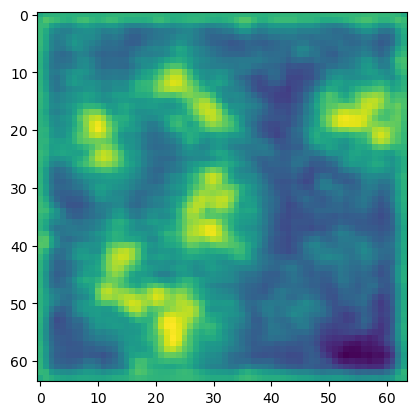

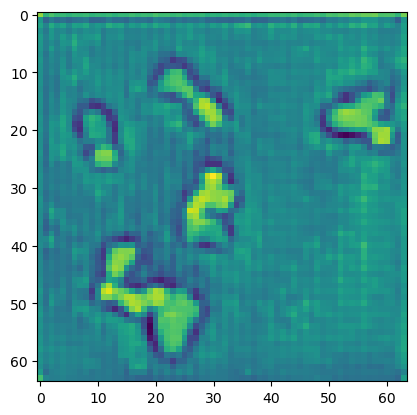

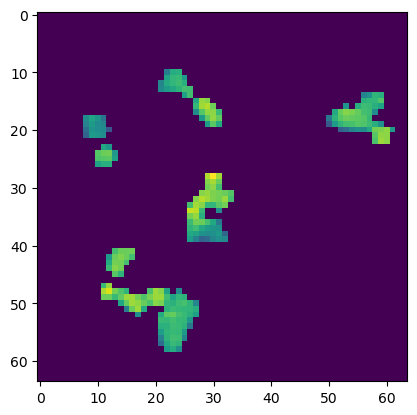

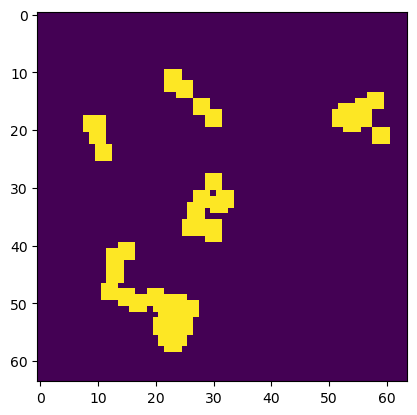

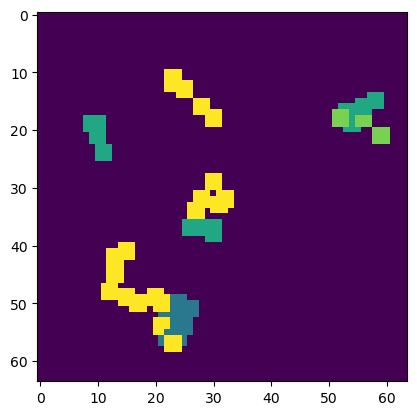

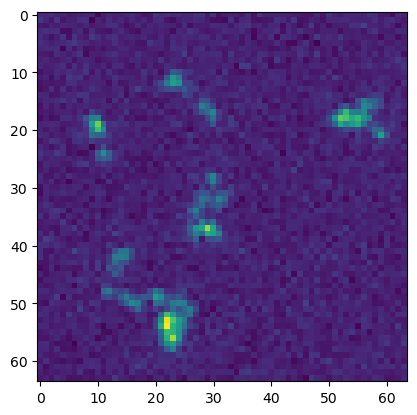

In [12]:
import matplotlib.pyplot as plt
plt.imshow(out1.detach().cpu().numpy())
plt.show()
plt.imshow(out2[:,:].detach().cpu().numpy())
plt.show()
plt.imshow(results[:,:].detach().cpu().numpy())
plt.show()
plt.imshow(in1[:,:].detach().cpu().numpy())
plt.show()
plt.imshow(in2[:,:].detach().cpu().numpy()*in1[:,:].detach().cpu().numpy())
plt.show()
plt.imshow(img[:,:].detach().cpu().numpy())

In [37]:
filename_m = dir_mask + 'mask_1.jpg'
mask = Image.open(filename_m)
mask2.max

<function Tensor.max>

'Z:/Dongyu Fan/2. Data/ImageProcessing/Simulation/2024-09-18/17-52/mask/mask_1.jpg'

In [14]:
from PIL import Image
filename = './data/imgs/0cdf5b5d0ce1_01.jpg'
img = Image.open(filename)

img2 = torch.from_numpy(BasicDataset.preprocess(None, img, 1, is_mask=False))

In [19]:
filename_m = './data/masks/fff9b3a5373f_14_mask.gif'
mask = Image.open(filename_m)
mask2 = torch.from_numpy(BasicDataset.preprocess([0,1], img, 1, is_mask=True))

In [20]:
mask2

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])